In [12]:
import requests
from bs4 import BeautifulSoup
import json
import re
import pandas as pd
from tidytext import unnest_tokens
import nltk
from siuba import *

nltk.download('punkt')

import numpy as np
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
from matplotlib import pyplot as plt
from tidytext import *
from nltk import *
from nltk.corpus import stopwords

nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\danib\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\danib\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
def getChapterContent(url, chapter):
    page = requests.get(url + str(chapter))
    soup = BeautifulSoup(page.content, 'html.parser')
    elem = soup.find("td").findAll(text=True, recursive=False)
    
    
    foundTitle = False
    text = ""
    for el in elem:
        string = str(el)
        
        if re.search('[a-zA-Z]', string):
            
            string = string.replace('\n', " ")
            string = string.replace('\t', " ")
            string = string.replace('\r', " ")
            string = string.replace('\u3000', "")
            string = string.replace("<br />", "")
            string = string.replace("&uml;C", "")
            
            if not foundTitle:
                title = string
                foundTitle = True
            else:
                text += string
    
    return title, text

In [3]:
def writeBook(i, url, titles, texts):
    json_book = dict()
    
    json_book["url"] = url
    
    json_book["title"] = url.split("/")[-1]
    json_book["title"] = json_book["title"].split("_")[0]
    
    json_book["no_chapters"] = len(titles)
    json_book["titles"] = titles
    json_book["content"] = texts
    
    print(json_book["title"])
    
    f = open("HarryPotter_Book"+str(i), "w")
    f.write(json.dumps(json_book))

In [4]:
def readBook(i):
    g = open("HarryPotter_Book"+str(i), "r")
    file = g.read().splitlines()[0]
    info = json.loads(file)
    
    return info

In [88]:
urls = [
    'https://thefreeonlinenovel.com/con/harry-potter-and-the-sorcerers-stone_chapter-',
    'https://thefreeonlinenovel.com/con/harry-potter-and-the-chamber-of-secrets_page-',
    'https://thefreeonlinenovel.com/con/harry-potter-and-the-prisoner-of-azkaban_page-',
    'https://thefreeonlinenovel.com/con/harry-potter-and-the-goblet-of-fire_page-',
    'https://thefreeonlinenovel.com/con/harry-potter-and-the-order-of-the-phoenix_page-',
    'https://thefreeonlinenovel.com/con/harry-potter-and-the-half-blood-prince_page-',
    'https://thefreeonlinenovel.com/con/harry-potter-and-the-deathly-hallows_page-'
]

In [89]:
for i in range(len(urls)):
    url = urls[i]
    
    all_titles = list()
    all_texts = list()
    chapter = 1
    while True:
        try:
            title, text = getChapterContent(url, chapter)
            all_titles.append(title)
            all_texts.append(text)
            #print("Current chapter: ", chapter)
            chapter += 1
        except Exception as e:
            #print(e)
            break
    
    writeBook(i+1, url, all_titles, all_texts)
    print("Book: ", i+1)
    print("Total chapters: ", chapter-1)
    word_count = 0
    for text in all_texts:
        word_count += len(text.split(" "))
    print("Total words: ",word_count)
    print("\n")

harry-potter-and-the-sorcerers-stone
Book:  1
Total chapters:  17
Total words:  78626


harry-potter-and-the-chamber-of-secrets
Book:  2
Total chapters:  19
Total words:  86287


harry-potter-and-the-prisoner-of-azkaban
Book:  3
Total chapters:  22
Total words:  106277


harry-potter-and-the-goblet-of-fire
Book:  4
Total chapters:  37
Total words:  193535


harry-potter-and-the-order-of-the-phoenix
Book:  5
Total chapters:  38
Total words:  284048


harry-potter-and-the-half-blood-prince
Book:  6
Total chapters:  30
Total words:  171832


harry-potter-and-the-deathly-hallows
Book:  7
Total chapters:  37
Total words:  203505




In [13]:
def getRawBooksToDF():
    df = pd.DataFrame(columns=['content', 'chapter', 'book'])

    for i in range(7):
        info = readBook(i+1)
        

        book_text = ''.join((chapter for chapter in info["content"]))
        generator = ngrams(word_tokenize(book_text.lower()), 2)
        
        curr_df = pd.DataFrame({
            "content": info["content"],
            "chapter": list(range(1,info["no_chapters"]+1))
        })
        curr_df["book"] = info['title']
        curr_df["book_id"] = int(i+1)

        df = pd.concat([df, curr_df])

    df.reset_index(drop=True, inplace=True) 
    return df

In [24]:
def getNgrams(n):
    bigrams_df = pd.DataFrame(columns=["book", str(n)+"grams"])

    for i in range(7):
        info = readBook(i+1)
        
        book_text = ''.join((chapter for chapter in info["content"]))
        bigrams_generator = ngrams(word_tokenize(book_text.lower()), n)
        
        temp_bigrams_df = pd.DataFrame({
            "book": info['title'],
            str(n)+"grams": [ ' '.join(grams) for grams in bigrams_generator]
        })
        
        bigrams_df = pd.concat([bigrams_df, temp_bigrams_df])
        
    return bigrams_df

In [10]:
def removeStopWordsDF(ss_df):
    ss_df = (unnest_tokens(ss_df, "word", "content"))
    ss_df = ss_df[ss_df.word.notnull()]
    ss_df = ss_df[~ss_df['word'].isin(stopwords.words('english'))]
    ss_df.reset_index(drop=True, inplace=True)
    
    return ss_df
    

In [17]:
full_df = getRawBooksToDF()

In [8]:
pd.set_option('display.max_rows', 200)
full_df

,content,chapter,book,book_id
0,"Mr. and Mrs. Dursley, of number four, Privet D...",1,harry-potter-and-the-sorcerers-stone,1.0
1,Nearly ten years had passed since the Dursleys...,2,harry-potter-and-the-sorcerers-stone,1.0
2,The escape of the Brazilian boa constrictor ea...,3,harry-potter-and-the-sorcerers-stone,1.0
3,BOOM. They knocked again. Dudley jerked awake....,4,harry-potter-and-the-sorcerers-stone,1.0
4,Harry woke early the next morning. Although he...,5,harry-potter-and-the-sorcerers-stone,1.0
5,Harry's last month with the Dursleys wasn't fu...,6,harry-potter-and-the-sorcerers-stone,1.0
6,"The door swung open at once. A tall, black-hai...",7,harry-potter-and-the-sorcerers-stone,1.0
7,"There, look."" ""Where?"" ""Next to the tall kid w...",8,harry-potter-and-the-sorcerers-stone,1.0
8,Harry had never believed he would meet a boy h...,9,harry-potter-and-the-sorcerers-stone,1.0
9,Malfoy couldn't believe his eyes when he saw t...,10,harry-potter-and-the-sorcerers-stone,1.0


In [9]:
ss_df = removeStopWordsDF(full_df)

In [10]:
ss_df

,chapter,book,book_id,word
0,1,harry-potter-and-the-sorcerers-stone,1.0,mr
1,1,harry-potter-and-the-sorcerers-stone,1.0,mrs
2,1,harry-potter-and-the-sorcerers-stone,1.0,dursley
3,1,harry-potter-and-the-sorcerers-stone,1.0,number
4,1,harry-potter-and-the-sorcerers-stone,1.0,four
...,...,...,...,...
583323,37,harry-potter-and-the-deathly-hallows,7.0,pained
583324,37,harry-potter-and-the-deathly-hallows,7.0,harry
583325,37,harry-potter-and-the-deathly-hallows,7.0,nineteen
583326,37,harry-potter-and-the-deathly-hallows,7.0,years


In [11]:
count(ss_df[ss_df["book_id"] == 1], 'word', sort=True).head(20)

,word,n
0,harry,1213
1,said,794
2,ron,410
3,hagrid,336
4,back,261
5,hermione,257
6,one,253
7,got,206
8,didnt,195
9,could,195


In [12]:
cnt = count(ss_df, 'word', sort=True)

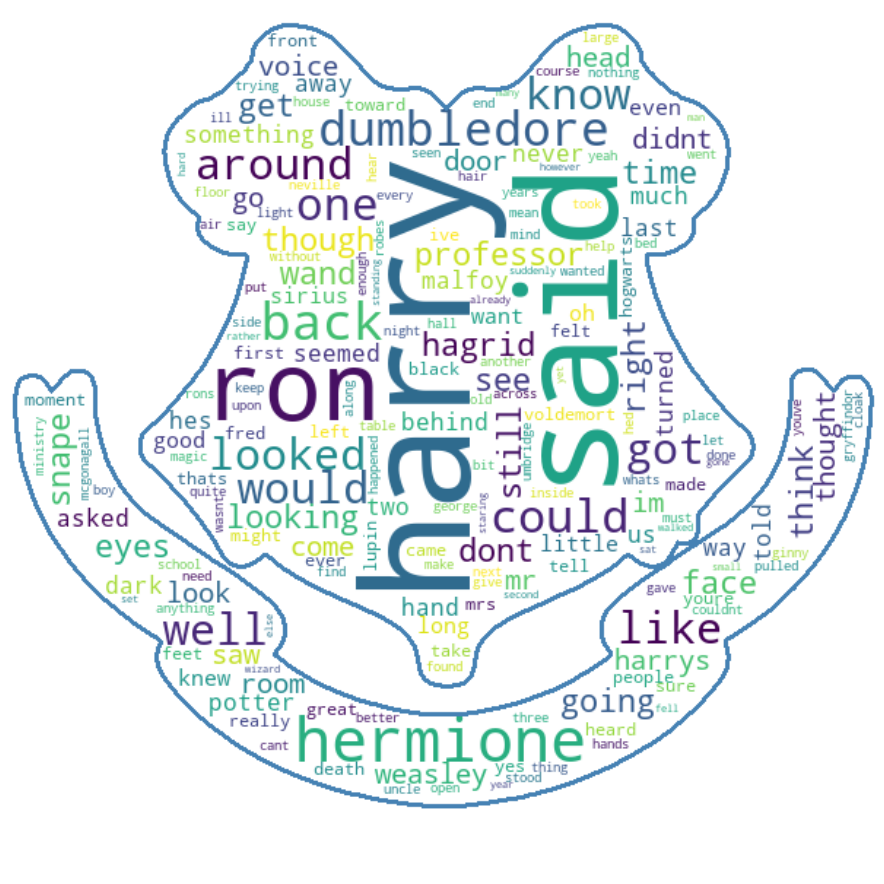

In [13]:
word_freq = pd.Series(cnt.n.values,index=cnt.word).to_dict()

mask = np.array(Image.open("Hogwarts-Logo-PNG-Transparent.png"))
mask[mask == 0] = 255

wordcloud = WordCloud(background_color='white',mask=mask, width=1000, height=800, contour_width=3, contour_color='steelblue',stopwords=[]).generate_from_frequencies(word_freq)
plt.figure(figsize = (16, 16), facecolor = None) 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

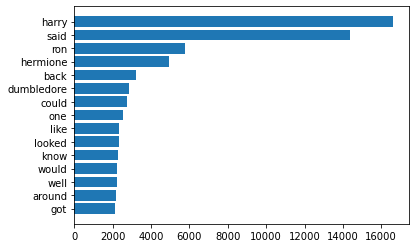

In [16]:
countWords =  list(cnt['word'].head(15))
occ = list(cnt['n'].head(15))

countWords.reverse()
occ.reverse()

plt.barh(countWords, occ, align='center')

plt.show()

In [15]:
count(ss_df, 'word', sort=True)

,word,n
0,harry,16613
1,said,14393
2,ron,5747
3,hermione,4928
4,back,3199
...,...,...
24086,cryin,1
24087,crybabies,1
24088,crutches,1
24089,crusty,1


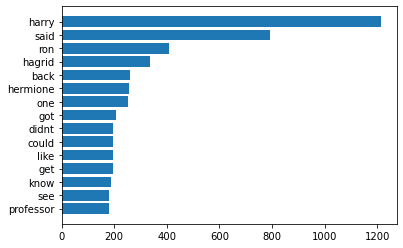

In [20]:
cnt = count(ss_df[ss_df["book_id"] == 1], 'word', sort=True)

countWords =  list(cnt['word'].head(15))
occ = list(cnt['n'].head(15))

countWords.reverse()
occ.reverse()

plt.barh(countWords, occ, align='center')

plt.show()

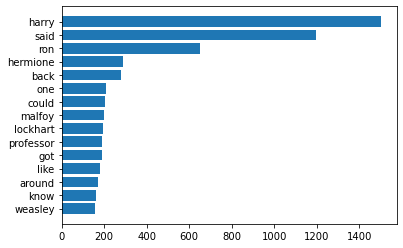

In [21]:
cnt = count(ss_df[ss_df["book_id"] == 2], 'word', sort=True)

countWords =  list(cnt['word'].head(15))
occ = list(cnt['n'].head(15))

countWords.reverse()
occ.reverse()

plt.barh(countWords, occ, align='center')

plt.show()

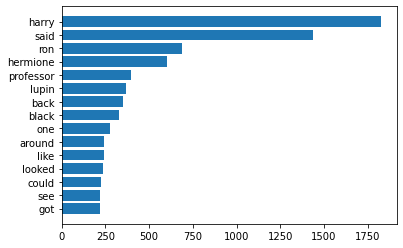

In [22]:
cnt = count(ss_df[ss_df["book_id"] == 3], 'word', sort=True)

countWords =  list(cnt['word'].head(15))
occ = list(cnt['n'].head(15))

countWords.reverse()
occ.reverse()

plt.barh(countWords, occ, align='center')

plt.show()

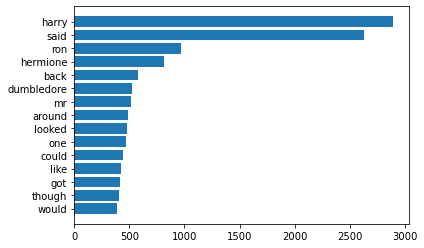

In [23]:
cnt = count(ss_df[ss_df["book_id"] == 4], 'word', sort=True)

countWords =  list(cnt['word'].head(15))
occ = list(cnt['n'].head(15))

countWords.reverse()
occ.reverse()

plt.barh(countWords, occ, align='center')

plt.show()

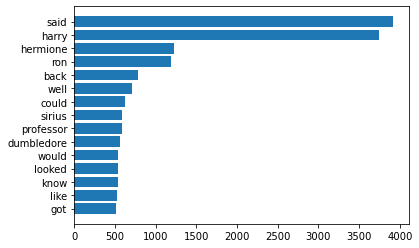

In [24]:
cnt = count(ss_df[ss_df["book_id"] == 5], 'word', sort=True)

countWords =  list(cnt['word'].head(15))
occ = list(cnt['n'].head(15))

countWords.reverse()
occ.reverse()

plt.barh(countWords, occ, align='center')

plt.show()

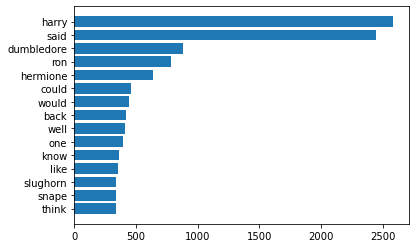

In [25]:
cnt = count(ss_df[ss_df["book_id"] == 6], 'word', sort=True)

countWords =  list(cnt['word'].head(15))
occ = list(cnt['n'].head(15))

countWords.reverse()
occ.reverse()

plt.barh(countWords, occ, align='center')

plt.show()

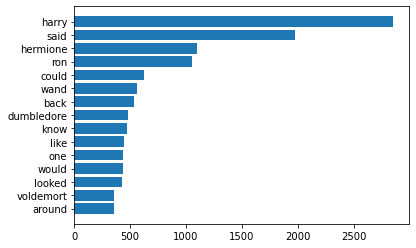

In [26]:
cnt = count(ss_df[ss_df["book_id"] == 7], 'word', sort=True)

countWords =  list(cnt['word'].head(15))
occ = list(cnt['n'].head(15))

countWords.reverse()
occ.reverse()

plt.barh(countWords, occ, align='center')

plt.show()

In [33]:
harry_potter_df = count(ss_df, _.book,  _.word, sort=True)

In [34]:
harry_potter_df

,book,word,n
0,harry-potter-and-the-order-of-the-phoenix,said,3917
1,harry-potter-and-the-order-of-the-phoenix,harry,3749
2,harry-potter-and-the-goblet-of-fire,harry,2892
3,harry-potter-and-the-deathly-hallows,harry,2852
4,harry-potter-and-the-goblet-of-fire,said,2627
...,...,...,...
66430,harry-potter-and-the-order-of-the-phoenix,innovation,1
66431,harry-potter-and-the-order-of-the-phoenix,innocently,1
66432,harry-potter-and-the-order-of-the-phoenix,innocentlooking,1
66433,harry-potter-and-the-deathly-hallows,stainedglass,1


In [37]:
book_tf_idf = bind_tf_idf(harry_potter_df, 'word', 'book', 'n')
book_tf_idf


,book,word,n,tf,idf,tf_idf
0,harry-potter-and-the-order-of-the-phoenix,said,3917,0.028088,0.000000,0.000000
1,harry-potter-and-the-order-of-the-phoenix,harry,3749,0.026883,0.000000,0.000000
2,harry-potter-and-the-goblet-of-fire,harry,2892,0.028168,0.000000,0.000000
3,harry-potter-and-the-deathly-hallows,harry,2852,0.027682,0.000000,0.000000
4,harry-potter-and-the-goblet-of-fire,said,2627,0.025587,0.000000,0.000000
...,...,...,...,...,...,...
66430,harry-potter-and-the-order-of-the-phoenix,innovation,1,0.000007,1.945910,0.000014
66431,harry-potter-and-the-order-of-the-phoenix,innocently,1,0.000007,0.336472,0.000002
66432,harry-potter-and-the-order-of-the-phoenix,innocentlooking,1,0.000007,1.252763,0.000009
66433,harry-potter-and-the-deathly-hallows,stainedglass,1,0.000010,1.945910,0.000019


In [38]:
arrange(book_tf_idf, -_.tf_idf)

,book,word,n,tf,idf,tf_idf
97,harry-potter-and-the-half-blood-prince,slughorn,337,0.003743,1.252763,0.004689
44,harry-potter-and-the-order-of-the-phoenix,umbridge,497,0.003564,0.847298,0.003020
247,harry-potter-and-the-goblet-of-fire,bagman,208,0.002026,1.252763,0.002538
279,harry-potter-and-the-chamber-of-secrets,lockhart,194,0.004091,0.559616,0.002289
82,harry-potter-and-the-prisoner-of-azkaban,lupin,369,0.006328,0.336472,0.002129
...,...,...,...,...,...,...
66205,harry-potter-and-the-deathly-hallows,staff,1,0.000010,0.000000,0.000000
66236,harry-potter-and-the-deathly-hallows,stage,1,0.000010,0.000000,0.000000
66355,harry-potter-and-the-deathly-hallows,contrary,1,0.000010,0.000000,0.000000
66380,harry-potter-and-the-order-of-the-phoenix,inky,1,0.000007,0.000000,0.000000


In [49]:
tf_idf_df = ungroup(group_by(arrange(book_tf_idf, -_.tf_idf), 'book').head(10))
tf_idf_df

,book,word,n,tf,idf,tf_idf
97,harry-potter-and-the-half-blood-prince,slughorn,337,0.003743,1.252763,0.004689
44,harry-potter-and-the-order-of-the-phoenix,umbridge,497,0.003564,0.847298,0.003020
247,harry-potter-and-the-goblet-of-fire,bagman,208,0.002026,1.252763,0.002538
279,harry-potter-and-the-chamber-of-secrets,lockhart,194,0.004091,0.559616,0.002289
82,harry-potter-and-the-prisoner-of-azkaban,lupin,369,0.006328,0.336472,0.002129
473,harry-potter-and-the-goblet-of-fire,winky,145,0.001412,1.252763,0.001769
1018,harry-potter-and-the-goblet-of-fire,champions,85,0.000828,1.945910,0.001611
1056,harry-potter-and-the-deathly-hallows,xenophilius,83,0.000806,1.945910,0.001568
637,harry-potter-and-the-deathly-hallows,griphook,119,0.001155,1.252763,0.001447
1497,harry-potter-and-the-half-blood-prince,mclaggen,65,0.000722,1.945910,0.001405


In [50]:
ordered_tf_idf_df = arrange(tf_idf_df, _.book, -_.tf_idf)
ordered_tf_idf_df

,book,word,n,tf,idf,tf_idf
279,harry-potter-and-the-chamber-of-secrets,lockhart,194,0.004091,0.559616,0.002289
504,harry-potter-and-the-chamber-of-secrets,dobby,139,0.002931,0.336472,0.000986
2894,harry-potter-and-the-chamber-of-secrets,gilderoy,37,0.000780,1.252763,0.000977
2258,harry-potter-and-the-chamber-of-secrets,myrtle,47,0.000991,0.847298,0.000840
808,harry-potter-and-the-chamber-of-secrets,riddle,100,0.002109,0.336472,0.000709
2829,harry-potter-and-the-chamber-of-secrets,lockharts,38,0.000801,0.847298,0.000679
8570,harry-potter-and-the-chamber-of-secrets,stall,12,0.000253,1.945910,0.000492
8746,harry-potter-and-the-chamber-of-secrets,kwikspell,12,0.000253,1.945910,0.000492
1498,harry-potter-and-the-chamber-of-secrets,diary,64,0.001349,0.336472,0.000454
2973,harry-potter-and-the-chamber-of-secrets,justin,36,0.000759,0.559616,0.000425


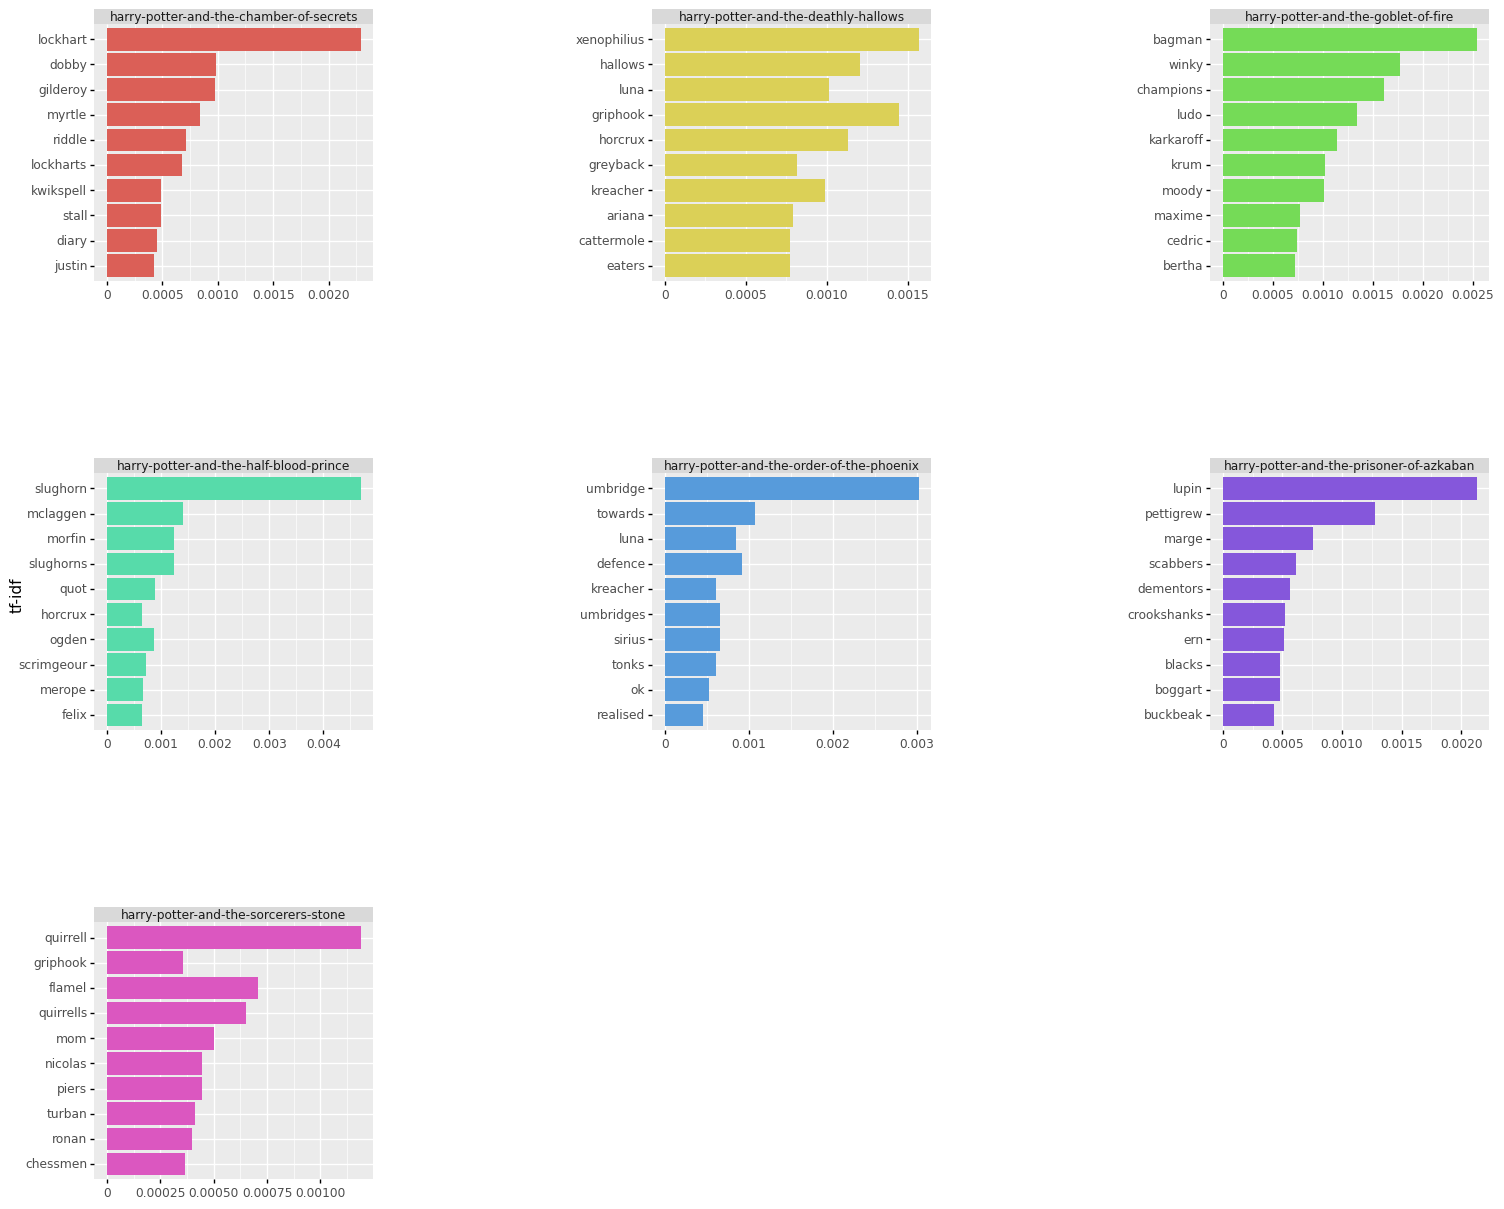

<ggplot: (-9223371862562976336)>

In [79]:
from siuba.dply.forcats import fct_reorder
from plotnine import *

ggplt = (ggplot(ordered_tf_idf_df)  + theme(figure_size=(18, 15)) + aes(x=fct_reorder(ordered_tf_idf_df['word'], x=ordered_tf_idf_df['tf_idf']), y='tf_idf', fill='book') + coord_flip() + geom_col(show_legend = False) + facet_wrap('~book', ncol = 3, scales = "free") + labs(x = "tf-idf", y = None) + theme(subplots_adjust={'wspace': 0.25}) + theme(subplots_adjust={'wspace': 1, 'hspace': 0.75}) + scale_x_discrete() ) 
ggplt

In [23]:
bigrams_df

,book,bigrams


In [25]:
nigrams = getNgrams(2)

In [26]:
nigrams

,book,2grams
0,harry-potter-and-the-sorcerers-stone,mr. and
1,harry-potter-and-the-sorcerers-stone,and mrs.
2,harry-potter-and-the-sorcerers-stone,mrs. dursley
3,harry-potter-and-the-sorcerers-stone,"dursley ,"
4,harry-potter-and-the-sorcerers-stone,", of"
...,...,...
245500,harry-potter-and-the-deathly-hallows,years .
245501,harry-potter-and-the-deathly-hallows,. all
245502,harry-potter-and-the-deathly-hallows,all was
245503,harry-potter-and-the-deathly-hallows,was well
